In [2]:
import augwrap as aw
from glob import glob
import os
import matplotlib.pyplot as plt
import albumentations as A
import cv2
import xml.etree.ElementTree as ET
from tqdm import tqdm
import time
import random

In [3]:
img_path = "../data/images"
xml_path = "../data/annotations"
images = glob(os.path.join(img_path, '*'))
xmls = glob(os.path.join(xml_path, '*.xml'))
images.sort()
xmls.sort()
classes = []
with open('../data/labels.txt', 'r') as f:
    while True:
        line = f.readline()
        if not line: break
        classes.append(line.strip())

In [4]:
dataset = aw.data.BaseDataset(images, xmls, classes)
dataset = aw.data.LoadImages(dataset)
dataset = aw.data.LoadPascalVOCLabels(dataset)

In [5]:
transform = A.Compose([
    A.OneOf([
        A.Sequential([
            A.Rotate(limit=5, p=1, border_mode=0),
            aw.augmentations.MixUp(dataset, rate_range=(0, 0.1), mix_label=False, p=0.5),
            A.RandomBrightnessContrast(p=1),
            A.RGBShift(p=1, r_shift_limit=(-10, 10), g_shift_limit=(-10, 10), b_shift_limit=(-10, 10)),
            A.ISONoise(p=0.5)
        ]),
        A.Sequential([
            aw.augmentations.Mosaic(
                dataset,
                transforms=[
                    A.Rotate(limit=5, p=1, border_mode=0),
                    aw.augmentations.MixUp(dataset, rate_range=(0, 0.1), mix_label=False, p=0.5),
                    A.RandomBrightnessContrast(p=1),
                    A.RGBShift(p=1, r_shift_limit=(-10, 10), g_shift_limit=(-10, 10), b_shift_limit=(-10, 10)),
                    A.ISONoise(p=0.5)
                ],
                always_apply=True
            ),
        ])
    ], p=1),
    
], bbox_params=A.BboxParams(format=dataset.bbox_format, min_area=0.5, min_visibility=0.2, label_fields=['labels']))

transformed = aw.data.Augmentations(dataset, transform)

box: [0.6649217117308135, 0.08702095929800996, 0.9991170831088285, 0.12689288693437925], label: Baskin_robbins


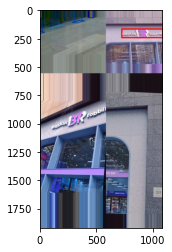

In [6]:
data = transformed[3210]
img = data['image']
for box, label in zip(data['bboxes'], data['labels']):
    box = list(box)
    print(f'box: {box}, label: {label}')
    box[0] = int(box[0] * img.shape[1])
    box[1] = int(box[1] * img.shape[0])
    box[2] = int(box[2] * img.shape[1])
    box[3] = int(box[3] * img.shape[0])
    img = cv2.rectangle(img, box[0:2], box[2:4], (255, 0, 0), 10)
plt.imshow(img)

In [7]:
res_path = '../data/annoted'
if not os.path.isdir(res_path): os.mkdir(res_path)
if not os.path.isdir(os.path.join(res_path, 'images')): os.mkdir(os.path.join(res_path, 'images'))
if not os.path.isdir(os.path.join(res_path, 'xmls')): os.mkdir(os.path.join(res_path, 'xmls'))
length = transformed.__len__()
epoch = 3

for ep in range(epoch):
    indexes = list(range(length))
    random.shuffle(indexes)
    for i in tqdm(range(length), desc=f'epoch {ep}'):
        i = indexes[i]
        file_no = ep*length+i
        output = transformed[i]
        # make image
        cv2.imwrite(os.path.join(res_path, 'images', f'{file_no}.jpg'), output['image'])

        # make xml
        root = ET.Element('annotation')
        folder = ET.SubElement(root, 'folder')
        folder.text = os.path.join(res_path, 'images')
        filename = ET.SubElement(root, 'filename')
        filename.text = f'{file_no}.jpg'
        size = ET.SubElement(root, 'size')
        width = ET.SubElement(size, 'width')
        height = ET.SubElement(size, 'height')
        depth = ET.SubElement(size, 'depth')
        h, w, d = output['image'].shape
        width.text = str(w)
        height.text = str(h)
        depth.text = str(d)
        for label, bbox in zip(output['labels'], output['bboxes']):
            obj = ET.SubElement(root, 'object')
            name = ET.SubElement(obj, 'name')
            name.text = label
            pose = ET.SubElement(obj, 'pose')
            pose.text = 'Unspecified'
            truncated = ET.SubElement(obj, 'truncated')
            truncated.text = '0'
            difficult = ET.SubElement(obj, 'difficult')
            difficult.text = '0'
            bndbox = ET.SubElement(obj, 'bndbox')
            xmin = ET.SubElement(bndbox, 'xmin')
            xmin.text = str(int(bbox[0] * w + 0.5))
            ymin = ET.SubElement(bndbox, 'ymin')
            ymin.text = str(int(bbox[1] * h + 0.5))
            xmax = ET.SubElement(bndbox, 'xmax')
            xmax.text = str(int(bbox[2] * w + 0.5))
            ymax = ET.SubElement(bndbox, 'ymax')
            ymax.text = str(int(bbox[3] * h + 0.5))
        tree = ET.ElementTree(root)
        tree.write(os.path.join(res_path, 'xmls', f'{file_no}.xml'))
        

epoch 2: 100%|██████████| 39834/39834 [5:44:54<00:00,  1.92it/s]   
